In [1]:
#hide
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#hide
%load_ext autoreload
%autoreload 2

%matplotlib inline
%cd /content/gdrive/My Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [3]:
__all__ ='icnr_init PixelShuffle_ICNR double_conv_max UnetBlock UNet'.split(" ")


In [4]:
#hide
# !git clone https://github.com/prajwal-suresh13/dl_lib.git

In [5]:
from dl_lib.core.utils import *
from dl_lib.core.models.basicmodels import *

In [7]:
def icnr_init(x, scale=2, init=nn.init.kaiming_normal_):
    "ICNR init of `x`, with `scale` and `init` function"
    ni,nf,h,w = x.shape
    ni2 = int(ni/(scale**2))
    k = init(x.new_zeros([ni2,nf,h,w])).transpose(0, 1)
    k = k.contiguous().view(ni2, nf, -1) 
    #https://stackoverflow.com/questions/48915810/what-does-contiguous-do-in-pytorch
    k = k.repeat(1, 1, scale**2) # repeat on the mentioned dim
    k = k.contiguous().view([nf,ni,h,w]).transpose(0, 1)
    return k

In [8]:
class PixelShuffle_ICNR(nn.Sequential):
    def __init__(self, ni, nf=None, scale=2, blur=False):
        super().__init__()
        nf = ifnone(nf, ni)
        layers = [conv_layer(ni, nf*(scale**2), ks=1, stride=1), nn.PixelShuffle(scale)]
        layers[0][0].weight.data.copy_(icnr_init(layers[0][0].weight.data))
        if blur: layers+=[nn.ReflectionPad2d((1,0,1,0)), nn.AvgPool2d(2,stride=1)]
        super().__init__(*layers)

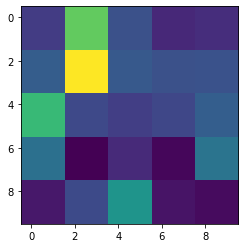

In [9]:
#hide
from torch import nn
import matplotlib.pyplot as plt

upscale_factor = 2
input = torch.randn(4, 3, 5, 5)
pixelshuffle = nn.PixelShuffle(upscale_factor)
conv = nn.Conv2d(3, 4 * (upscale_factor ** 2), 3, 1, 1, bias=0)

weight = icnr_init(conv.weight, scale=2, init=nn.init.kaiming_normal_)
conv.weight.data.copy_(weight)
output = conv(input)
output = pixelshuffle(output)
plt.imshow(output.detach().numpy()[0, 0, :])

In [10]:
def double_conv_max(n_in, n_out, ks=3, stride=1, maxpool=True):
    layers = [conv_layer(n_in, n_out, ks=ks, stride=stride), conv_layer(n_out, n_out,ks=ks, stride=stride)]
    if maxpool: layers+=[nn.MaxPool2d(kernel_size=2, stride=2)]
    return nn.Sequential(*layers)

In [11]:
class UnetBlock(nn.Module):
    def __init__(self, up_in_c, x_in_c):
        super().__init__()
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2)
        self.bn = nn.BatchNorm2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = ni//2
        self.double_conv = double_conv_max(ni,nf, maxpool=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, up_in, hook):
        up_out = self.shuf(up_in)
        # print(up_out.shape)
        hook = hook
        # print(hook.shape)
        if hook.shape[-2:]!=up_out.shape[-2:]:
            up_out = F.interpolate(up_out, hook.shape[-2:], mode='nearest')
        cat = self.relu(torch.cat([up_out, self.bn(hook)],dim=1))
        return self.double_conv(cat)

In [12]:
class UNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.input_channels, self.output_channels =input_channels, output_channels
        filters =[self.input_channels, 64, 128, 256, 512,1024]

        encoder_layers = [double_conv_max(filters[i],filters[i+1]) for i in range(4)]
        self.encoder = nn.Sequential(*encoder_layers)
        self.blocks = [enc[1] for enc in self.encoder]


        self.mid_layers = double_conv_max(filters[-2],filters[-1],maxpool=False) 

        filters = list(reversed(filters))
        decoder_layers = [UnetBlock(filters[i],filters[i+1]) for i in range(4)]
        self.decoder = nn.Sequential(*decoder_layers)
        

        self.output_layer = nn.Conv2d(in_channels=64, out_channels= self.output_channels, kernel_size=1)

    def forward(self, image):
        with Hooks(self.blocks, hook_outputs) as hooks:
            x = self.encoder(image)
            self.hooks = [o.output for o in hooks]
        # print(x.shape)
        # for h in self.hooks: print(h.shape)

        self.hooks = list(reversed(self.hooks))

        x = self.mid_layers(x)
        # print(x.shape)

        for layer,h in zip(self.decoder, self.hooks):
            x = layer(x, h)
            # print(x.shape)
        x = self.output_layer(x)
        # print(x.shape)
        return x

In [13]:
#hide
UNet(3,2)

UNet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), paddi

In [15]:
#hide
!pip install fire
!python dl_lib/notebook2script.py notebooks/core/models/unet.ipynb dl_lib/core/models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Converted notebooks/core/models/unet.ipynb to dl_lib/core/models/unet.py
